## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer, BertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset5
from bert import CustomBert3
from multilabel_cross_fold import MultilabelStratifiedKFold
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from eda import eda
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
%%time
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



CPU times: user 31.9 s, sys: 288 ms, total: 32.2 s
Wall time: 32.4 s


In [4]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)

In [7]:
num_workers = 10
bs = 2
TextDataset = TextDataset5

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_bert_2'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10
p_aug = 0.0

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.bert, lr / 100, weight_decay)
    )

Fold 1 started at Sun Jan 12 13:17:44 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


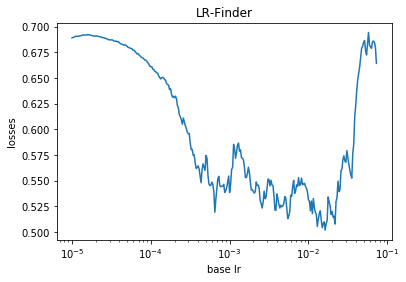

Starting inference for model: checkpoints/siamese_bert_2_fold_1_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_1_best.pth



Fold 2 started at Sun Jan 12 13:19:28 2020
Starting inference for model: checkpoints/siamese_bert_2_fold_2_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_2_best.pth



Fold 3 started at Sun Jan 12 13:20:08 2020
Starting inference for model: checkpoints/siamese_bert_2_fold_3_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_3_best.pth



Fold 4 started at Sun Jan 12 13:20:49 2020
Starting inference for model: checkpoints/siamese_bert_2_fold_4_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_4_best.pth



Fold 5 started at Sun Jan 12 13:21:29 2020
Starting inference for model: checkpoints/siamese_bert_2_fold_5_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_5_best.pth



Fold 6 started at Sun Jan 12 13:22:10 2020
Starting inference for model: checkpoints/siamese_bert_2_fold_6_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_6_best.pth



Fold 7 started at Sun Jan 12 13:22:50 2020
Starting inference for model: checkpoints/siamese_bert_2_fold_7_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_7_best.pth



Fold 8 started at Sun Jan 12 13:23:31 2020
Starting inference for model: checkpoints/siamese_bert_2_fold_8_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_8_best.pth



Fold 9 started at Sun Jan 12 13:24:12 2020
Starting inference for model: checkpoints/siamese_bert_2_fold_9_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_9_best.pth



Fold 10 started at Sun Jan 12 13:24:54 2020
Starting inference for model: checkpoints/siamese_bert_2_fold_10_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_10_best.pth



OOF score: 0.4072779272181386


In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    #if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#KFold 5: distilbert: 0.4160
#GKFold 5: distilbert: ~0.4005, ~0.4130, distilbert eda: ~0.4000, ~0.4200 (unsure), bert siamese: 0.4040, 0.4188
    # smoothing y dist -> ~0.005 CV improve
#GKFold 10: distilbert: 0.4012, ~0.4195, bert siamese(smoothing): 0.4059, 0.4206, 0.4275, 0.4449
    #bert siamese(smoothing) with token_type_ids: 0.4091. 0.4236. 0.4317, 0.4507
#MLFold 5: bert siamese: 0.4118, 0.4355, 04373

In [12]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

def scale(x, d):
    if d: return (x//(1/d))/d
    else: return x

indices = [2, 5, 12, 13, 14, 15]
ds = [10, 5, 5, 20, 5, 5]
discrete_cols = np.array(TARGETS)[indices]
print(discrete_cols)

def ahmet_round(preds, ds=ds, indices=indices):
    new_preds = preds.copy()
    for idx, d in zip(indices, ds):
        new_preds[:,idx] = scale(preds[:,idx], d)
    return new_preds

['question_conversational' 'question_has_commonly_accepted_answer'
 'question_type_compare' 'question_type_consequence'
 'question_type_definition' 'question_type_entity']


In [13]:
from scipy.stats import spearmanr
opt_ds = []
opt_indices = []
for idx in range(N_TARGETS):
    opt_score = 0
    opt_d = None
    for d in [5, 10, 15, 20, 33, None]:
        score = spearmanr(scale(oofs[:,idx], d), y[:,idx])[0]
        if score > opt_score:
            opt_score = score
            opt_d = d
            print(idx, d, score)
    if opt_d:
        opt_ds.append(opt_d)
        opt_indices.append(idx)

0 5 0.35748461649154545
0 10 0.380668036349349
0 15 0.3810901339401092
0 33 0.38231519560352667
1 5 0.6434340711280797
1 10 0.654464315064117
1 15 0.6568358143569775
1 20 0.6576479586316334
1 33 0.6592887913107177
1 None 0.6593130237388888
2 5 0.48254867977986193
3 5 0.27560795385076076
3 10 0.2943231217792544
3 15 0.29582007736158544
3 20 0.3004969114309008
4 5 0.35538018010414185
5 5 0.4329031007174081
6 5 0.3129247495971262
6 10 0.34198308395031285
6 15 0.34805238794033483
6 20 0.34880592830164575
6 33 0.34963270240566263
6 None 0.35123827921482936
7 5 0.5040311301734963
7 10 0.5043101540286224
7 15 0.5058429654400719
8 5 0.5726266087649661
8 10 0.5760955518350709
8 15 0.5800264897828459
9 10 0.08969605281958963
9 15 0.10871047037617018
9 20 0.12994739942549677
10 5 0.4469473307046903
10 10 0.4585223315763625
10 15 0.4621709515898523
10 None 0.46237580873269896
11 5 0.747756793443779
11 10 0.7513463418364396
12 5 0.5113126861379328
13 5 0.19857116969599642
13 10 0.2708429330185385
1

In [14]:
opt_ds, opt_indices

([33, 5, 20, 5, 5, 15, 15, 20, 10, 5, 10, 10, 5, 15, 33, 20, 33, 33, 20],
 [0, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 24, 25, 26])

In [15]:
spearmanr_np(ahmet_round(oofs, opt_ds, opt_indices), y)

0.44875554705184395

In [16]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0
spearmanr_np(ahmet_round(oofs_alt, opt_ds, opt_indices), y)

0.44875554705184395

In [17]:
spearmanr_np(oofs, y)

0.4072779272181386

In [18]:
spearmanr_np(round_preds(oofs, high_num=3), y)

0.42236241442872585

In [19]:
spearmanr_np(ahmet_round(oofs), y)

0.4300843543932324

In [20]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [21]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.853018,0.617180,0.382198,0.370596,0.518384,0.359814,0.722360,0.746878,0.726018,0.003642,0.735705,0.777806,0.018418,0.490569,0.004061,0.014299,0.074986,0.161376,0.766533,0.000421,0.857084,0.596165,0.206815,0.779299,0.738042,0.323386,0.018850,0.035214,0.815299,0.651187
1,46,0.463809,0.303101,0.013858,0.677689,0.615474,0.840056,0.428377,0.377351,0.047001,0.019989,0.491317,0.212637,0.005332,0.000667,0.000849,0.016720,0.876086,0.313873,0.080907,0.000187,0.255557,0.750522,0.486603,0.847640,0.917800,0.571543,0.936475,0.196137,0.044569,0.611213
2,70,0.706061,0.543938,0.036346,0.608770,0.796940,0.900900,0.516476,0.442521,0.316346,0.003214,0.312920,0.700119,0.012928,0.061982,0.000896,0.004554,0.137062,0.127528,0.778509,0.000223,0.667331,0.678771,0.304314,0.859471,0.851207,0.466306,0.046356,0.053576,0.867011,0.590839
3,132,0.559168,0.167995,0.006551,0.597354,0.632365,0.860149,0.389012,0.245148,0.194528,0.010134,0.593951,0.162895,0.002065,0.004112,0.000390,0.002938,0.801885,0.312630,0.634054,0.000073,0.439252,0.804373,0.596403,0.869517,0.918579,0.649474,0.848649,0.335751,0.638258,0.683632
4,200,0.789290,0.317324,0.046013,0.799990,0.734556,0.882231,0.688761,0.701370,0.181001,0.028828,0.318962,0.514542,0.006206,0.023455,0.007856,0.067014,0.185505,0.161823,0.557902,0.002686,0.386504,0.749067,0.553056,0.885397,0.882999,0.635982,0.219512,0.194548,0.709846,0.590568


In [22]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [24]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.061499,3.0
question_not_really_a_question,0.087765,5.0
answer_plausible,0.135163,9.0
answer_relevance,0.164055,9.0
question_type_consequence,0.176557,5.0
answer_well_written,0.225050,9.0
answer_helpful,0.229894,9.0
question_expect_short_answer,0.300067,5.0
answer_type_procedure,0.307688,5.0
answer_satisfaction,0.333638,17.0


In [25]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

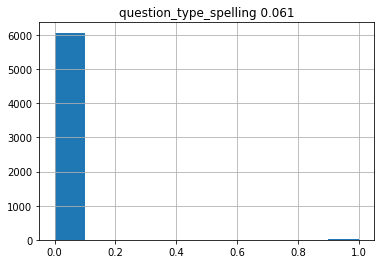

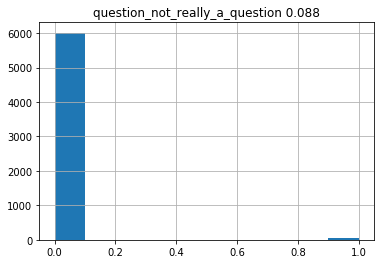

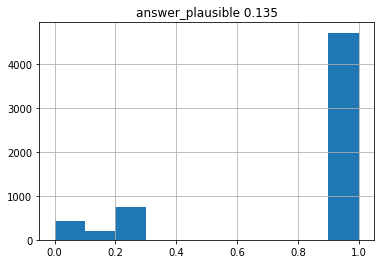

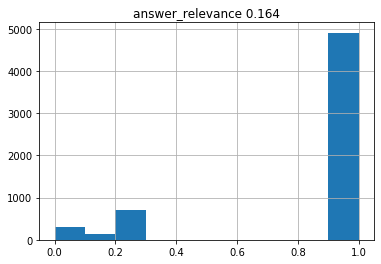

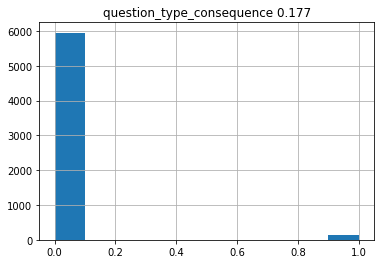

In [26]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


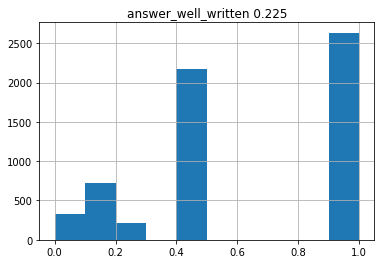

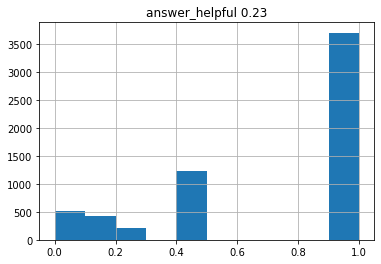

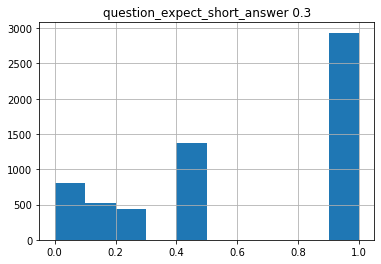

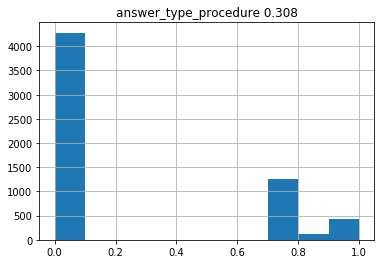

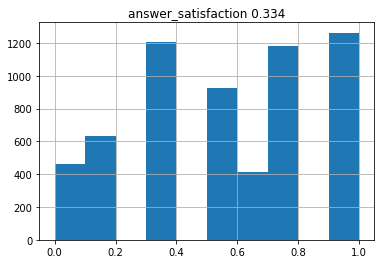

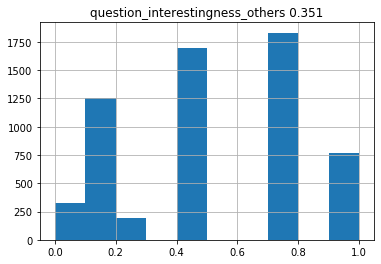

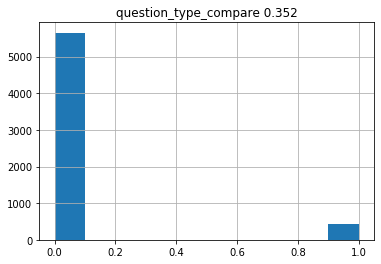

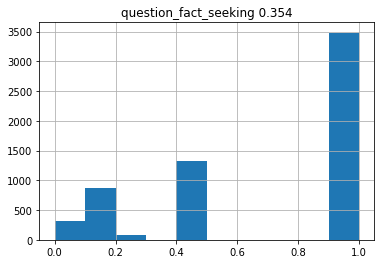

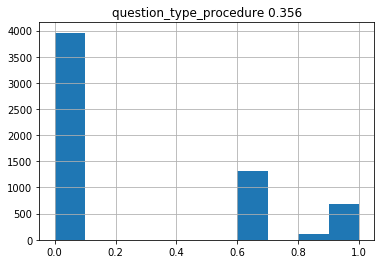

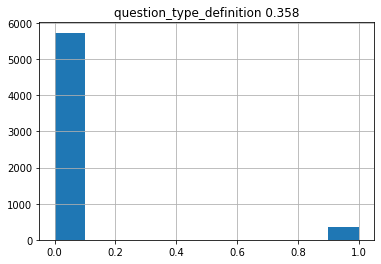

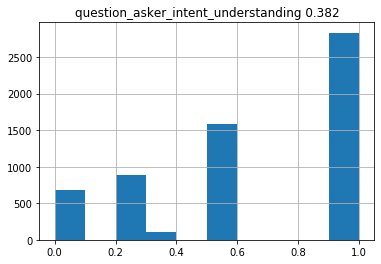

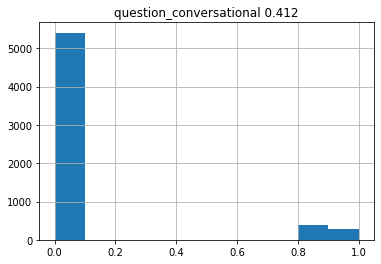

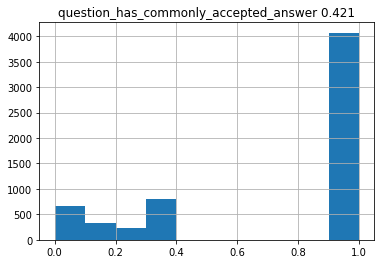

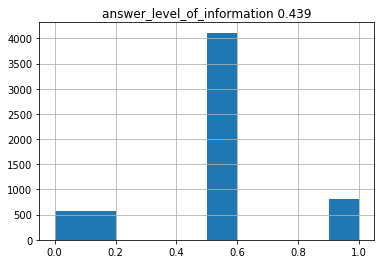

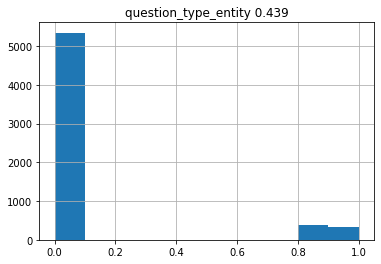

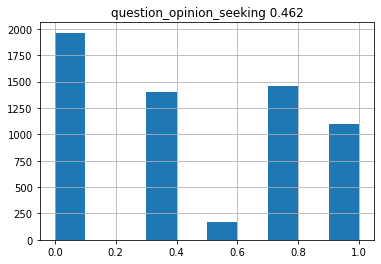

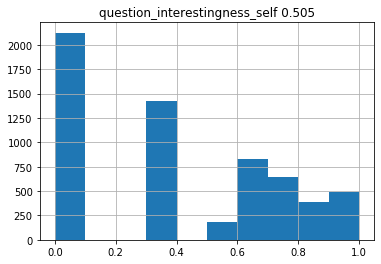

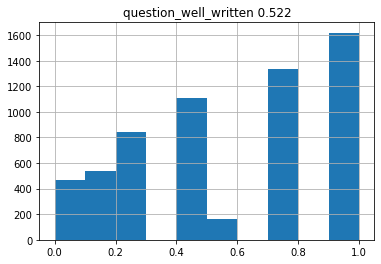

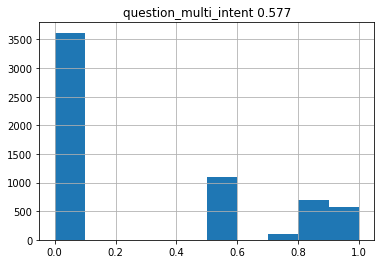

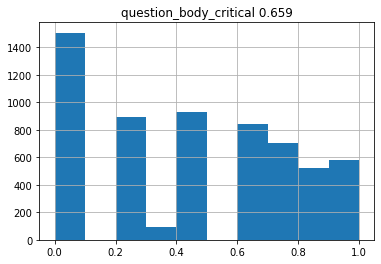

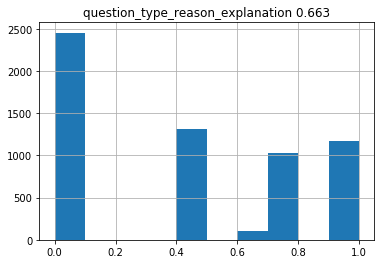

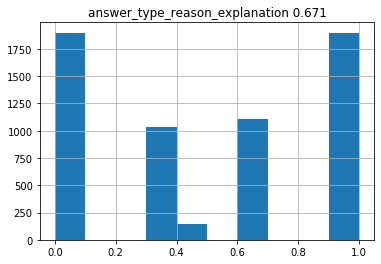

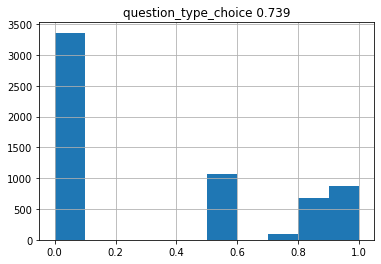

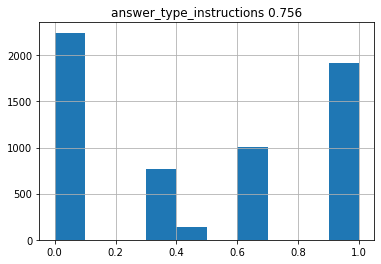

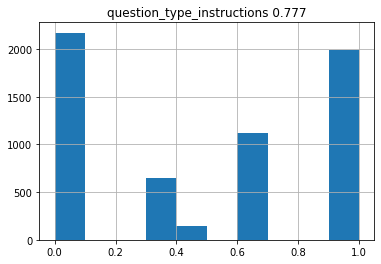

In [27]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

In [43]:
t = 'reason_explanation'
q_idx, a_idx = TARGETS.index(f'question_type_{t}'), TARGETS.index(f'answer_type_{t}')
q_idx, a_idx

(18, 28)

In [44]:
spearmanr(oofs[:,q_idx], y[:,q_idx])[0], spearmanr(oofs[:,a_idx], y[:,a_idx])[0]

(0.6632769071097786, 0.6714154697460958)

In [49]:
spearmanr(oofs[:,q_idx]+oofs[:,a_idx], y[:,q_idx])[0], spearmanr(oofs[:,q_idx]+oofs[:,a_idx], y[:,a_idx])[0]

(0.6327367934425631, 0.6451087874747531)